Este notebook tem como objetivo trazer algumas analises a respeito do modelo utilizado para o projeto do Khiata.

In [2]:
# Importações para análise de dados
import pandas as pd

# Importações para o Pré-processamento
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

# Importação para separar o treino e teste
from sklearn.model_selection import train_test_split

# Importação para aumentar nossa base de dados, duplicamento de dados
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Importações para o Cross Validation
from sklearn.model_selection import KFold

# Para serializar
import pickle as pkl

df = pd.read_csv(r'C:\Users\enzorocha-ieg\OneDrive - Instituto Germinare\Área de Trabalho\Khiata_Dados\python\utils\FormsKhiataTratada.csv')

##### Com base na análise dos resultados e considerando o equilíbrio entre precisão e capacidade de generalização, o Decision Tree com o critério Gini ajustado se destaca como a melhor escolha. Este modelo apresentou:
 
1. Equilíbrio entre as classes: Com precisão e recall mais balanceados para as classes "Sim" e "Não".
2. Acurácia média: 0.65, conforme cross-validation, o que demonstra um bom nível de confiabilidade e generalização para novos dados.
3. Menor tendência de enviesamento: Diferente do Naive Bayes, que apresentou forte enviesamento, o Decision Tree com Gini distribuiu as previsões de forma mais uniforme.

##### IA

In [3]:
# Atributos
atributos = df.drop('Utilizaria_App_Costura', axis=1)

# Resposta
resposta = df['Utilizaria_App_Costura']

# Instanciando o labelEncoder - resposta
# Usando o labelEncoder para a resposta
label_encoder = LabelEncoder()

# Transformando os atributos de valores categóricos para valores numéricos
# Usando o ColumnTransformer() para transformar e o OrdinalEncoder() para ordenar as colunas

preprocessador = ColumnTransformer(transformers = [
    ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include = ['object', 'bool'])),
    ],
    remainder='passthrough', # para preservar as colunas não transformadas no dataset, as colunas transformardas vão aparecer em primeiro no df
    verbose_feature_names_out = False # False para não colocar prefixo _categoricas nas colunas transformadas
)

# preprocessador para variáveis de resposta
resposta_pre = label_encoder.fit_transform(resposta) # resposta_pre variável sendo a coluna de resposta preprocessadas

# preprocessador atributos
atributos_pre = pd.DataFrame(preprocessador.fit_transform(atributos), columns = preprocessador.get_feature_names_out())

# Nome das colunas na nova ordem - O columnsTransformer ordena de acordo com as novas transformações
colunas_novas = preprocessador.get_feature_names_out()

# Capturando os nomes originais
colunas_originais = atributos.columns

# Criando o dataFrame com a mesma ordem inicial de colunas
atributos_pre = atributos_pre[colunas_originais] # atributos_pre variáveis sendo a coluna de atributos preprocessadas.

X_treino, X_teste, y_treino, y_teste = train_test_split(atributos_pre, resposta_pre, test_size = 0.20, random_state=42)

smote = SMOTE(k_neighbors = 5, random_state = 42)
X_treino_smote, y_treino_smote = smote.fit_resample(X_treino, y_treino)

# Parâmetros
parametros_gini = {
    'criterion': ['gini'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Criando classificador com os hyper parameters
classificador_gini_smote_cross_validation = tree.DecisionTreeClassifier(
    criterion='gini', 
    max_depth=4, 
    max_features='log2', 
    min_samples_leaf=10, 
    min_samples_split=2, 
    splitter='best'
)

# Criando objeto GridSearchCV, para o Cross Validation com os hyperparametros
gini_cross_validantion_grid = GridSearchCV(
    estimator=classificador_gini_smote_cross_validation, 
    param_grid=parametros_gini, 
    scoring='accuracy', 
    cv=KFold(n_splits=5, random_state=42, shuffle=True)
)

# Treinando o Modelo com o SMOTE
gini_cross_validantion_grid.fit(X_treino_smote, y_treino_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=4, max_features='log2',
                                              min_samples_leaf=10),
             param_grid={'criterion': ['gini'],
                         'max_depth': [None, 2, 4, 6, 8, 10, 12],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

##### Gráficos

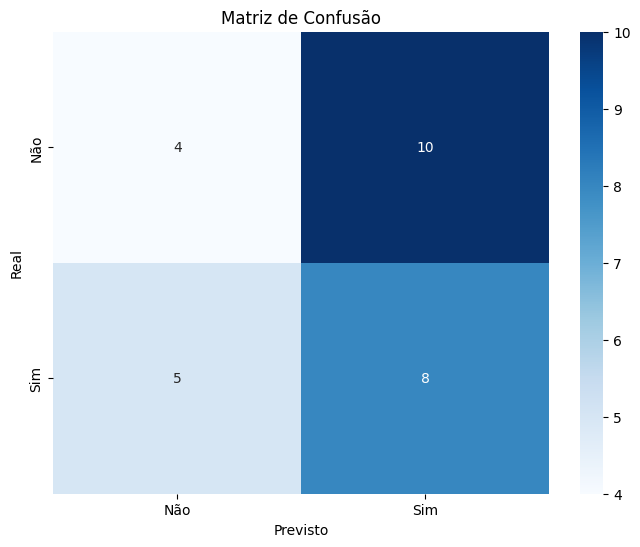

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Fazer previsões no conjunto de teste
y_pred = gini_cross_validantion_grid.predict(X_teste)

# Criar a matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()


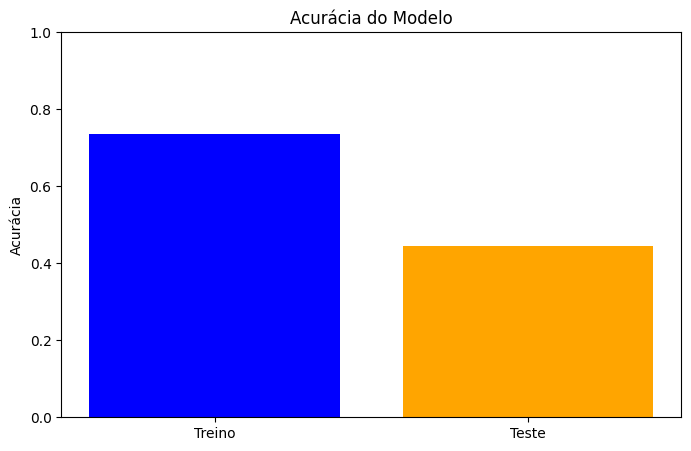

In [8]:
from sklearn.metrics import accuracy_score

# Calcular a acurácia para os conjuntos de treino e teste
accuracy_train = accuracy_score(y_treino_smote, gini_cross_validantion_grid.predict(X_treino_smote))
accuracy_test = accuracy_score(y_teste, y_pred)

# Criar um gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(['Treino', 'Teste'], [accuracy_train, accuracy_test], color=['blue', 'orange'])
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo')
plt.ylim(0, 1)
plt.show()

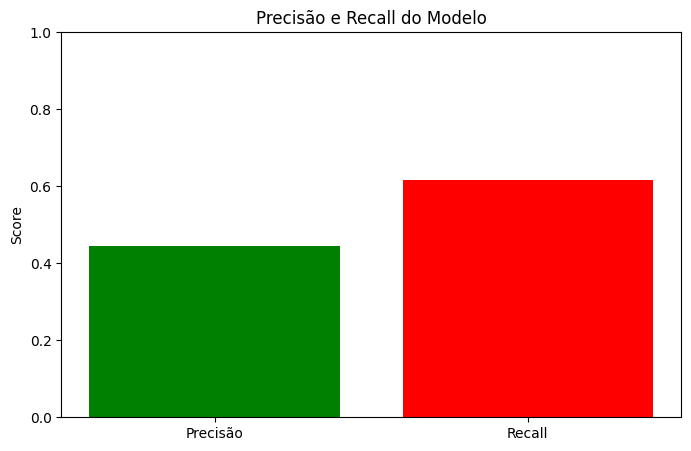

In [9]:
from sklearn.metrics import precision_score, recall_score

# Calcular precisão e recall
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)

# Criar um gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(['Precisão', 'Recall'], [precision, recall], color=['green', 'red'])
plt.ylabel('Score')
plt.title('Precisão e Recall do Modelo')
plt.ylim(0, 1)
plt.show()

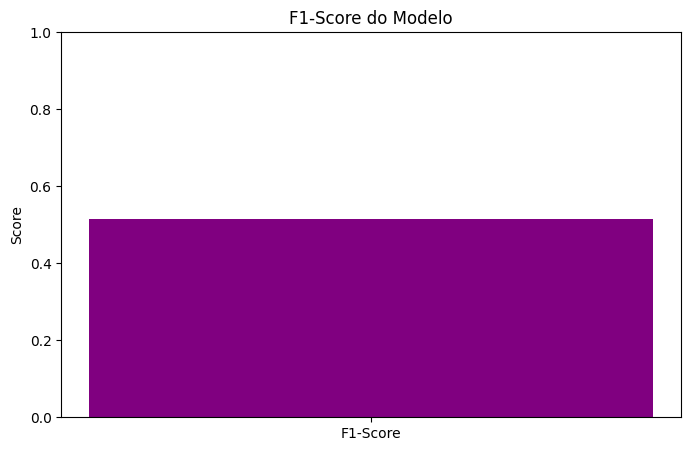

In [10]:
from sklearn.metrics import f1_score

# Calcular o F1-score
f1 = f1_score(y_teste, y_pred)

# Criar um gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(['F1-Score'], [f1], color='purple')
plt.ylabel('Score')
plt.title('F1-Score do Modelo')
plt.ylim(0, 1)
plt.show()

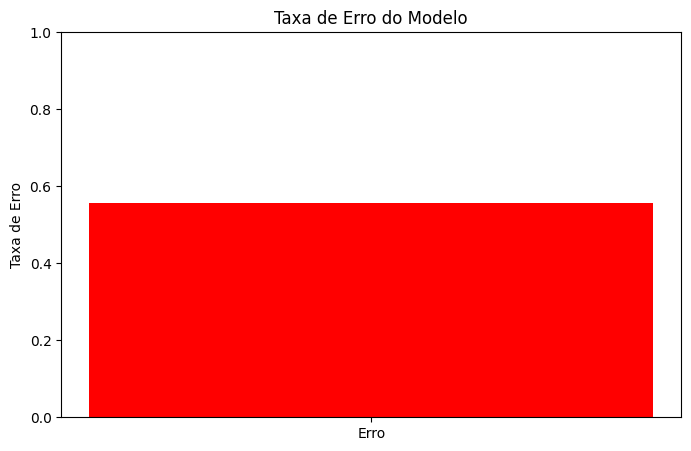

In [11]:
# Calcular a taxa de erro
error_rate = 1 - accuracy_score(y_teste, y_pred)

# Criar um gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(['Erro'], [error_rate], color='red')
plt.ylabel('Taxa de Erro')
plt.title('Taxa de Erro do Modelo')
plt.ylim(0, 1)
plt.show()